In [1]:
%matplotlib inline


Spatial Transformer Networks
============================

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import datetime
from datetime import date, datetime

plt.ion()   # interactive mode


Loading the data
----------------

In this post we experiment with the classic CIFAR dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [3]:
p_batchsize = 64
cuda = torch.cuda.is_available()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=None)
train_mean = trainset.data.mean(axis=(0,1,2))/255
train_std  = trainset.data.std(axis=(0,1,2))/255
print(f'Trainset mean = {train_mean}')
print(f'Trianset std = {train_std}')

test_mean = testset.data.mean(axis=(0,1,2))/255
test_std  = testset.data.std(axis=(0,1,2))/255
print(f'Testset mean = {test_mean}')
print(f'Testset std = {test_std}')

train_transform = transforms.Compose([transforms.ToTensor()
                                     ,transforms.Normalize((train_mean[0], train_mean[1], train_mean[2]), (train_std[0],train_std[1], train_std[2])) 
                                     ,transforms.RandomCrop(size = (32,32),padding = 4,padding_mode='edge')
                                     ,transforms.RandomHorizontalFlip(p=0.5)
                                     ])
  
test_transform = transforms.Compose([transforms.ToTensor()
                ,transforms.Normalize((test_mean[0],test_mean[1],test_mean[2]), (test_std[0],test_std[1],test_std[2]))])

trainset.transform = train_transform  
testset.transform = test_transform

dataloader_args = dict(shuffle=True, batch_size=p_batchsize,num_workers=2, pin_memory=True) if cuda else dict (shuffle=True, batch_size=p_batchsize)
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)
  
dataloader_args = dict(shuffle=False, batch_size=p_batchsize,num_workers=2, pin_memory=True) if cuda else dict (shuffle=False, batch_size=p_batchsize)
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Trainset mean = [0.49139968 0.48215841 0.44653091]
Trianset std = [0.24703223 0.24348513 0.26158784]
Testset mean = [0.49421428 0.48513139 0.45040909]
Testset std = [0.24665252 0.24289226 0.26159238]


In [4]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:: /_static/img/stn/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 28, 28]             760
           Conv2d-11           [-1, 20, 10, 10]           5,020
        Dropout2d-12           [-1, 20, 10, 10]               0
           Linear-13                   [-1, 50]          25,050
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



In [7]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.49139968, 0.48215841, 0.44653091])
    std = np.array([0.24703223, 0.24348513, 0.26158784])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



In [8]:
strt_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

==> Training started at - 27/12/2021 05:30:33


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.297566
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.288164


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.0712, Accuracy: 2614/10000 (26%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.034581
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.200098

Test set: Average loss: 1.8934, Accuracy: 3374/10000 (34%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.008852
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.957583

Test set: Average loss: 1.7829, Accuracy: 3758/10000 (38%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.974003
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.860214

Test set: Average loss: 1.6973, Accuracy: 3986/10000 (40%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.888172
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.909005

Test set: Average loss: 1.6656, Accuracy: 4126/10000 (41%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.866444
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.855111

Test set: Average loss: 1.6296, Accuracy: 4269/10000 (43%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.783785
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.759674

Test set: Average loss: 1.5928, Accuracy: 4389/10000 (44%)

Tra

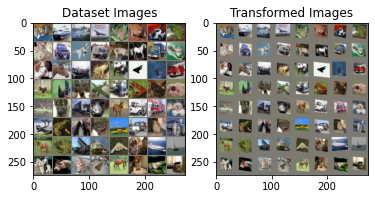

In [9]:
strt_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f'==> Training started at - {strt_time}')
for epoch in range(1, 50 + 1):
    train(epoch)
    test()
end_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f'==> Training ended at - {end_time}')
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [10]:
PATH = "\Spatial_transformation_model.h5"
#PATH = "\content\drive\MyDrive\EVA-7-Repo\Spatial_transformation_model.h5"
torch.save(model,PATH)
#model1 = torch.load(PATH)